# Recommender Systems

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import chardet
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

It appears that there is inconsistency in the text encoding used in various data files. As a result, we must verify the encoding to ensure accurate data reading from these files.

In [2]:
def get_file_encoding(file_path):
    """
    This function checks the text enconding used in a particular file
    
    :param file_path: The file path you wish to examine for its encoding
    :return: String containing enconding type
    """
    
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

In [3]:
# Loading ratings data
ratings_path = "./ml-1m/ml-1m/ratings.dat"
ratings = pd.read_csv(ratings_path, delimiter="::", header=None, engine='python', encoding=get_file_encoding(ratings_path))
ratings = ratings.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3:"Timestamp"}) # Set ratings column names

ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
#Loading movies data
movies_path = "./ml-1m/ml-1m/movies.dat"
movies = pd.read_csv(movies_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(movies_path))
movies = movies.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})

movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#Loading users data
users_path = "./ml-1m/ml-1m/users.dat"
users = pd.read_csv(users_path, delimiter="::", header=None, engine='python', encoding= get_file_encoding(users_path))
users = users.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Pre-processing Data

In [6]:
le = LabelEncoder()

In [7]:
unique_users_ids = ratings['UserID'].unique()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_users = users[users['UserID'].isin(unique_users_ids)]

unique_movies_ids = ratings['MovieID'].unique()
# Assuming your movies features matrix is named 'movies_features_df'
filtered_movies = movies[movies['MovieID'].isin(unique_movies_ids)]


filtered_movies.loc[:, 'MovieID'] = le.fit_transform(filtered_movies['MovieID'])
filtered_users.loc[:, 'UserID'] = le.fit_transform(filtered_users['UserID'])

In [8]:
user_movie_ratings = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

In [9]:
# Encode columns (MovieIDs)
user_movie_ratings.columns = le.fit_transform(user_movie_ratings.columns)

# Encode row names (UserIDs)
user_movie_ratings.index = le.fit_transform(user_movie_ratings.index)

# Matrix Factorization

In [10]:
class MatrixFactorization:
    def __init__(self, K=10, max_iter=75, eta=0.005, lamda=0.05):
        self.K = K  # Number of latent features
        self.max_iter = max_iter  # Maximum number of iterations
        self.eta = eta  # Learning rate
        self.lamda = lamda  # Regularization parameter
        # self.U = None  # Initialize user matrix randomly
        # self.M = None  # Initialize movie matrix randomly
        # self.train_set_values=None

    def fit(self, train_set):
        self.zero_rows=np.where(~train_set.values.any(axis=1))[0]
        self.zero_columns=np.where(~train_set.values.any(axis=0))[0]
        prev_rmse = float('inf')
        consecutive_increase_count = 0
        probe_subset = [(i, j, train_set.iloc[i, j]) for i in range(len(train_set)) for j in range(len(train_set.columns)) if train_set.iloc[i, j] > 0]
        N, Z = train_set.shape  # Dimensions of the user-item matrix
        self.train_set_values=train_set.values
        self.U = np.random.rand(N, self.K)  # Initialize user matrix randomly
        self.M = np.random.rand(Z, self.K)  # Initialize movie matrix randomly
        for step in range(self.max_iter):
            # Calculate errors for non-zero entries in train_set
            errors = (train_set.values > 0) * (train_set.values - np.dot(self.U, self.M.T))

            # Calculate gradients for U and M using matrix operations
            gradient_U = 2 * (np.dot(errors, self.M) - self.lamda * self.U)
            gradient_M = 2 * (np.dot(errors.T, self.U) - self.lamda * self.M)

            # Update U and M using matrix operations
            self.U += self.eta * gradient_U
            self.M += self.eta * gradient_M

            # Calculate RMSE on the probe subset
            probe_rmse = self.get_rmse(probe_subset)
            probe_mae = self.get_mae(probe_subset)
            print("Iteration:", step + 1, " RMSE:", probe_rmse, " MAE:", probe_mae)

            # Check for convergence by comparing RMSE with the previous iteration
            if probe_rmse >= prev_rmse:
                consecutive_increase_count += 1
                if consecutive_increase_count >= 2 and probe_rmse<=1:
                    print("Converged. RMSE did not decrease for 2 consecutive iterations.")
                    print('Train RMSE:',probe_rmse)
                    print('Train MAE:',probe_mae)
                    break
            else:
                consecutive_increase_count = 0

            prev_rmse = probe_rmse
        
        # print('Train RMSE:',probe_rmse)
        # print('Train MAE:',probe_mae)

        return probe_rmse,probe_mae

    def predict(self):
        return np.dot(self.U, self.M.T)
    

    def test_rmse_mae(self, test_data):
        test_data = test_data.values  # Convert test DataFrame to numpy array
        nR = np.dot(self.U, self.M.T)

        # Create a mask for non-zero entries in the test data
        non_zero_mask = (test_data > 0) & np.logical_not(np.isin(np.arange(len(test_data)), self.zero_rows)[:, np.newaxis]) & np.logical_not(np.isin(np.arange(len(test_data[0])), self.zero_columns))
        actual_ratings = test_data[non_zero_mask]
        predicted_ratings = nR[non_zero_mask]

        rmse = np.sqrt(np.mean((predicted_ratings - actual_ratings) ** 2))
        mae = np.mean(np.abs(predicted_ratings - actual_ratings))

        # print('Test RMSE:', rmse)
        # print('Test MAE:', mae)
        return rmse, mae


    def get_rmse(self, probe_subset):
        rmse = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = np.dot(self.U[i, :], self.M[j, :])
            rmse += (predicted_rating - actual_rating) ** 2
            count += 1
        rmse = np.sqrt(rmse / count)
        return rmse

    def get_mae(self, probe_subset):
        mae = 0
        count = 0
        for i, j, actual_rating in probe_subset:
            predicted_rating = np.dot(self.U[i, :], self.M[j, :])
            mae += np.abs(predicted_rating - actual_rating)
            count += 1
        mae = mae / count
        return mae
    



## Cross validation

In [11]:
def cross_validation(model, data_df, num_folds=5):

    # Assuming data_df is your DataFrame with ratings
    num_users, num_movies = data_df.shape

    # Create a list of (user, movie, rating) tuples from the DataFrame
    data = [(user, movie, data_df.iloc[user, movie]) for user in range(num_users) for movie in range(num_movies) if data_df.iloc[user, movie] != 0]

    # # Define the number of folds for cross-validation
    # num_folds = 5

    # Initialize KFold cross-validator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize empty DataFrames for train and test sets
    train_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]
    test_sets = [pd.DataFrame(np.zeros((num_users, num_movies))) for _ in range(num_folds)]

    # Iterate through the folds
    train_sum_rmse = 0
    train_sum_mae = 0

    test_sum_rmse = 0
    test_sum_mae = 0

    for fold, (train_index, test_index) in enumerate(kf.split(data), 1):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]
        
        # Fill train and test DataFrames with ratings from the respective data tuples
        for user, movie, rating in train_data:
            train_sets[fold - 1].iloc[user, movie] = rating
        
        for user, movie, rating in test_data:
            test_sets[fold - 1].iloc[user, movie] = rating
        
        # #Print train and test sets for each fold (optional)
        # print(f"Fold {fold} - Train Set:", np.count_nonzero(train_sets[fold - 1]))
        # print(train_sets[fold - 1])
        # print(f"Fold {fold} - Test Set:",np.count_nonzero(test_sets[fold - 1]))
        # print(test_sets[fold - 1])
        

        # mf = MatrixFactorization()
        mf = model
        (train_rmse,train_mae) = mf.fit(train_sets[fold - 1])
        #predicted_ratings = mf.predict()
        
        (test_rmse,test_mae) =mf.test_rmse_mae(test_sets[fold - 1])

        print('Train RMSE for fold:',fold,':', train_rmse)
        print('Train MAE for fold:',fold,':', train_mae)

        print('Test RMSE for fold:',fold,':', test_rmse)
        print('Test MAE for fold:',fold,':', test_mae)

        train_sum_rmse = train_sum_rmse + train_rmse
        train_sum_mae = train_sum_mae + train_mae


        test_sum_rmse = test_sum_rmse + test_rmse
        test_sum_mae = test_sum_mae + test_mae

    overall_train_rmse=train_sum_rmse/num_folds
    overall_train_mae=train_sum_mae/num_folds

    overall_test_rmse=test_sum_rmse/num_folds
    overall_test_mae=test_sum_mae/num_folds

    print('Overall Train RMSE:',overall_train_rmse)
    print('Overall Train MAE:',overall_train_mae)

    print('Overall Test RMSE:',overall_test_rmse)
    print('Overall Test MAE:',overall_test_mae)



    

## Implement

In [12]:
# #test on small subset #delete this sell after
# movies=movies.loc[:10,:]
# users=users.loc[:20,:]
# user_movie_ratings=user_movie_ratings.loc[:20,:10]

In [13]:
model=MatrixFactorization()
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 1.5678778181458741  MAE: 1.3921704978535563
Iteration: 2  RMSE: 1.3383345631078487  MAE: 1.1554230888809192
Iteration: 3  RMSE: 1.156481438242462  MAE: 0.9578672200137176
Iteration: 4  RMSE: 1.0170265997483554  MAE: 0.8304658962170535
Iteration: 5  RMSE: 0.9118571091393413  MAE: 0.7344988233711189
Iteration: 6  RMSE: 0.8323956196420137  MAE: 0.6574720748940983
Iteration: 7  RMSE: 0.7712576498295114  MAE: 0.6041405307130382
Iteration: 8  RMSE: 0.7228814108451349  MAE: 0.5583444555077717
Iteration: 9  RMSE: 0.6834181737267897  MAE: 0.5187559687204347
Iteration: 10  RMSE: 0.6503218480578004  MAE: 0.4842546177148295
Iteration: 11  RMSE: 0.6219276589453215  MAE: 0.4539277239452455
Iteration: 12  RMSE: 0.5971305577603285  MAE: 0.4310833597684817
Iteration: 13  RMSE: 0.575172023672377  MAE: 0.411038710508243
Iteration: 14  RMSE: 0.5555090123674061  MAE: 0.3926337878935127
Iteration: 15  RMSE: 0.5377363147544547  MAE: 0.3785864087201183
Iteration: 16  RMSE: 0.52154092000026

In [14]:
model=MatrixFactorization(K=5, max_iter=75, eta=0.005, lamda=0.1)
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 2.837049064342826  MAE: 2.6829431303844595
Iteration: 2  RMSE: 2.5803609131093794  MAE: 2.4119357608232574
Iteration: 3  RMSE: 2.3285816752973574  MAE: 2.142355775842157
Iteration: 4  RMSE: 2.088235622099143  MAE: 1.8807347641243066
Iteration: 5  RMSE: 1.8654484442002595  MAE: 1.6337855199262903
Iteration: 6  RMSE: 1.6646347856533177  MAE: 1.4341190101145815
Iteration: 7  RMSE: 1.4877977818818202  MAE: 1.2829787025189094
Iteration: 8  RMSE: 1.3345880014991298  MAE: 1.1464016367727843
Iteration: 9  RMSE: 1.2029468547901447  MAE: 1.0249097560841052
Iteration: 10  RMSE: 1.089962526940689  MAE: 0.9338627929401748
Iteration: 11  RMSE: 0.9925989090526305  MAE: 0.86358713026684
Iteration: 12  RMSE: 0.9081378419420263  MAE: 0.7985619537301638
Iteration: 13  RMSE: 0.8343485967084231  MAE: 0.7387950610247142
Iteration: 14  RMSE: 0.7694810494755192  MAE: 0.6841294053217601
Iteration: 15  RMSE: 0.7121800729545004  MAE: 0.6343030635444754
Iteration: 16  RMSE: 0.6613849032494549 

In [15]:
model=MatrixFactorization(K=5, max_iter=75, eta=0.01, lamda=0.05)
data_df=user_movie_ratings
cross_validation(model, data_df, num_folds=5)


Iteration: 1  RMSE: 2.3931775741956653  MAE: 2.137733595646503
Iteration: 2  RMSE: 1.8863976090743118  MAE: 1.6282020170156162
Iteration: 3  RMSE: 1.459635496408477  MAE: 1.249261423247431
Iteration: 4  RMSE: 1.141315763895872  MAE: 0.9832997080169413
Iteration: 5  RMSE: 0.9175008999114563  MAE: 0.7728319798852186
Iteration: 6  RMSE: 0.7590377134529673  MAE: 0.6201943817232405
Iteration: 7  RMSE: 0.6436581547323044  MAE: 0.5276367849223591
Iteration: 8  RMSE: 0.5579748043240509  MAE: 0.45552862641512104
Iteration: 9  RMSE: 0.4935528673422483  MAE: 0.40292079588816604
Iteration: 10  RMSE: 0.4444731999724137  MAE: 0.35969477072612577
Iteration: 11  RMSE: 0.40638716223325505  MAE: 0.32287585927289997
Iteration: 12  RMSE: 0.3761208041857036  MAE: 0.29150428352142455
Iteration: 13  RMSE: 0.3514119111524743  MAE: 0.26468586479307565
Iteration: 14  RMSE: 0.33068285304512224  MAE: 0.2416417282755382
Iteration: 15  RMSE: 0.3128475446361067  MAE: 0.22171730241267823
Iteration: 16  RMSE: 0.297160

# Visualization

## Data preparation

In [16]:
movies_df=filtered_movies
movies_df.loc[:, 'Year'] = movies_df['Title'].str.extract(r'\((\d{4})\)')[0]
movies_df=movies_df[['MovieID', 'Genres', 'Year']]
movies_df.loc[:,'Year'] = movies_df['Year'].astype(int)
# Convert 'Year' column to integers
movies_df.loc[:,'Year'] = movies_df['Year'].astype(int)
# Define function to categorize years into decades
def categorize_decade(year):
    return f'{year // 10 * 10}s'
# Apply the function to the 'Year' column and create a new column 'Decade'
movies_df['Decade'] = movies_df['Year'].apply(categorize_decade)

# Print the updated DataFrame
users_df=filtered_users[["UserID", "Gender", "Age"]]

In [17]:
model_v=MatrixFactorization()
data_df_v=user_movie_ratings
model_v.fit(data_df_v)
U = model_v.U
M = model_v.M

Iteration: 1  RMSE: 1.8304263229952922  MAE: 1.569867394017928
Iteration: 2  RMSE: 1.5468976171647726  MAE: 1.32563823084609
Iteration: 3  RMSE: 1.3234109843239217  MAE: 1.1382373468537264
Iteration: 4  RMSE: 1.1517689566954068  MAE: 0.9822620739762816
Iteration: 5  RMSE: 1.0210227369342546  MAE: 0.8687966660498221
Iteration: 6  RMSE: 0.9203038139916303  MAE: 0.7864895812150514
Iteration: 7  RMSE: 0.8407626094419157  MAE: 0.7262883930905456
Iteration: 8  RMSE: 0.7760719392702677  MAE: 0.6769099142259838
Iteration: 9  RMSE: 0.7220322205777977  MAE: 0.6306583467046871
Iteration: 10  RMSE: 0.6759291859658343  MAE: 0.5877464170708515
Iteration: 11  RMSE: 0.6359862327095226  MAE: 0.5517353544452055
Iteration: 12  RMSE: 0.6009931445451946  MAE: 0.5191827025644081
Iteration: 13  RMSE: 0.5700814875001867  MAE: 0.48928061842536846
Iteration: 14  RMSE: 0.5425960146961141  MAE: 0.46181980824272384
Iteration: 15  RMSE: 0.5180220685534218  MAE: 0.43658936052097236
Iteration: 16  RMSE: 0.49594374389

# PCA

## Users

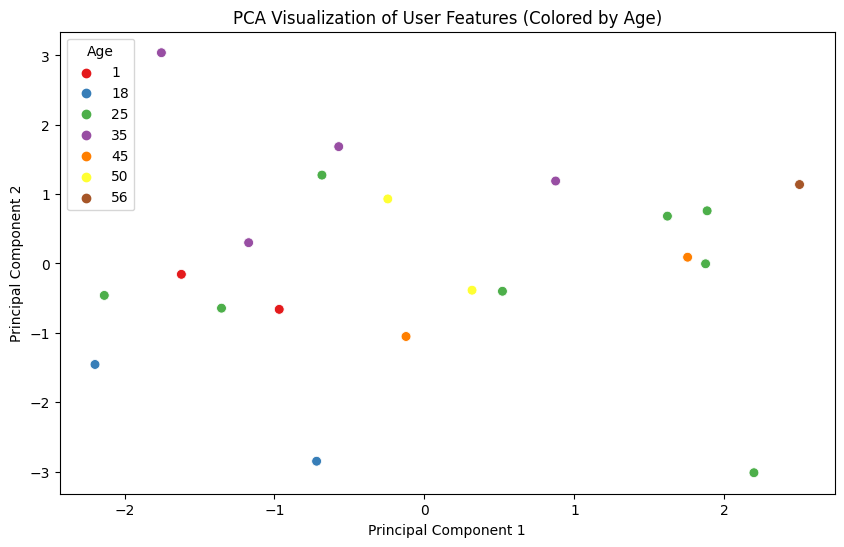

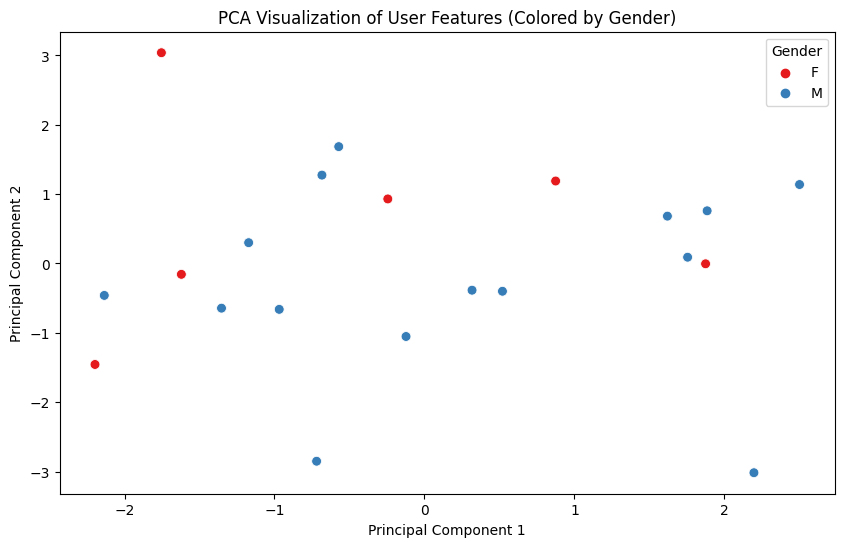

In [18]:
# Apply PCA with 2 components for visualization
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(U)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate PCA results with user information
final_df = pd.concat([pca_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Age', data=final_df, palette='Set1', s=50)
plt.title('PCA Visualization of User Features (Colored by Age)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Alternatively, you can color points by gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Gender', data=final_df, palette='Set1', s=50)
plt.title('PCA Visualization of User Features (Colored by Gender)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Movies

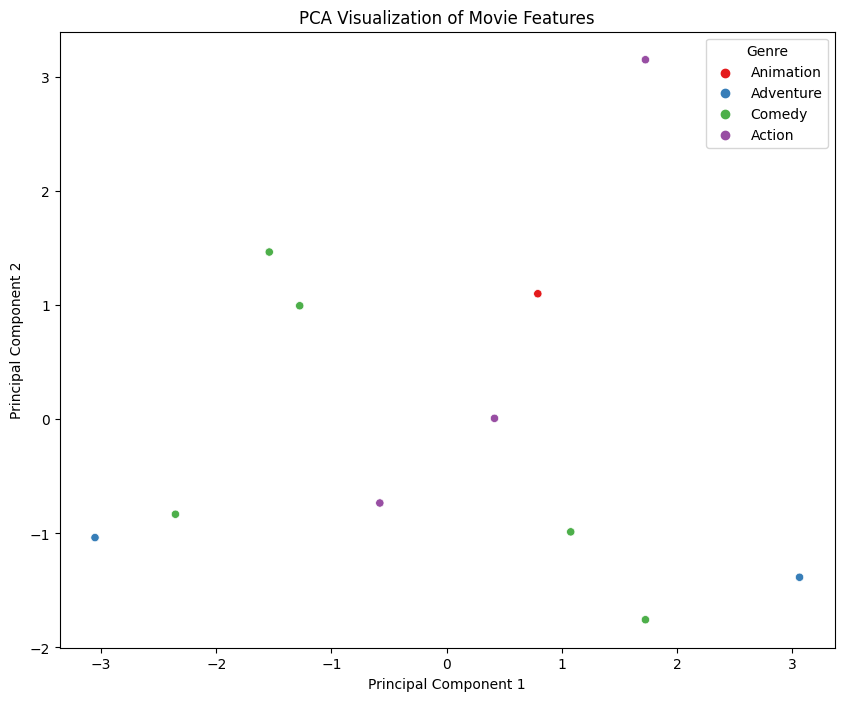

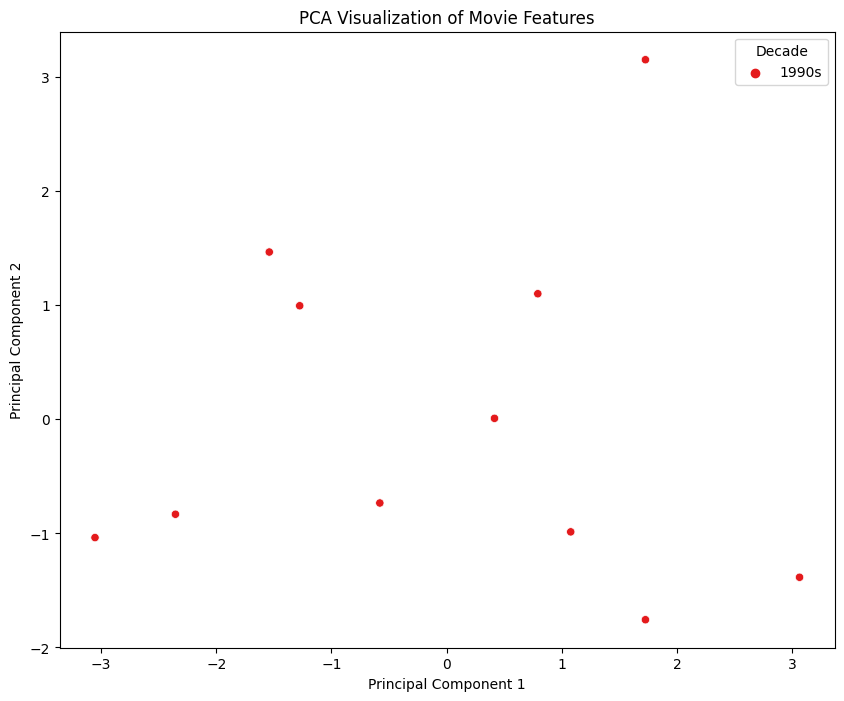

In [19]:
# Assuming you have the matrix of features stored in variable M (10, 67)
# For demonstration purposes, generating a random matrix M (10, 67)

# Apply PCA to reduce dimensions
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(M)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Extracting genre information for labeling
pca_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  # Extract first genre as an example

# Plotting using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Genre', data=pca_df, palette='Set1')
plt.title('PCA Visualization of Movie Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Genre')
plt.show()

pca_df['Decade'] = movies_df['Decade']

# Plotting using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Decade', data=pca_df, palette='Set1', legend='full')
plt.title('PCA Visualization of Movie Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Decade', loc='upper right')
plt.show()







# t-SNE

## Users

C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Program Files\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Program Files\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


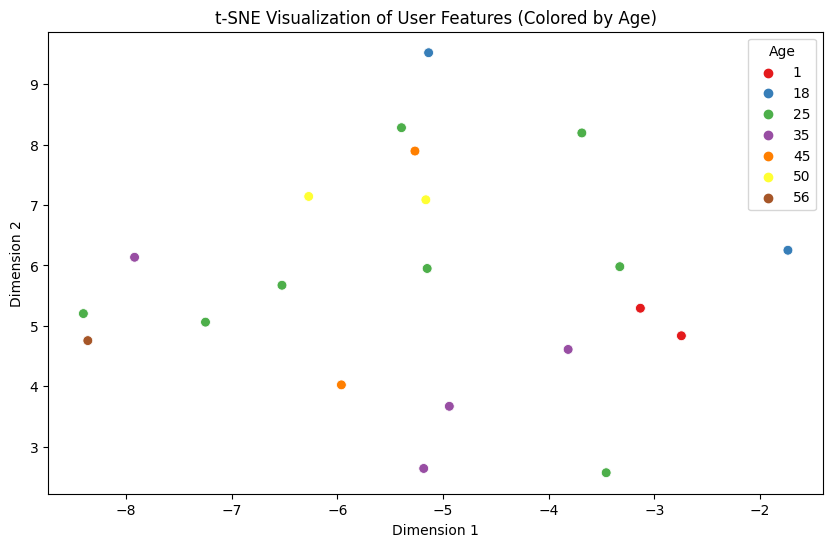

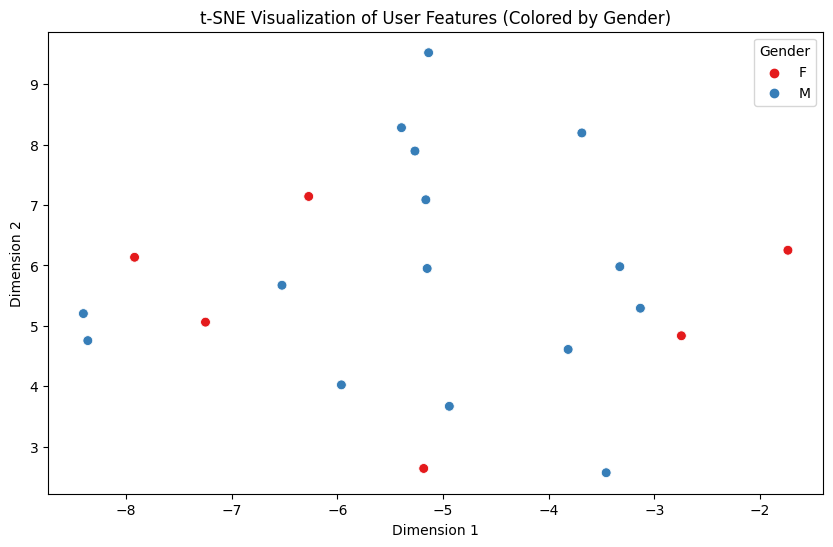

In [23]:
# Apply t-SNE with 2 components for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(U)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Concatenate t-SNE results with user information
final_tsne_df = pd.concat([tsne_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Age', data=final_tsne_df, palette='Set1', s=50)
plt.title('t-SNE Visualization of User Features (Colored by Age)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Alternatively, you can color points by gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Gender', data=final_tsne_df, palette='Set1', s=50)
plt.title('t-SNE Visualization of User Features (Colored by Gender)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## Movies

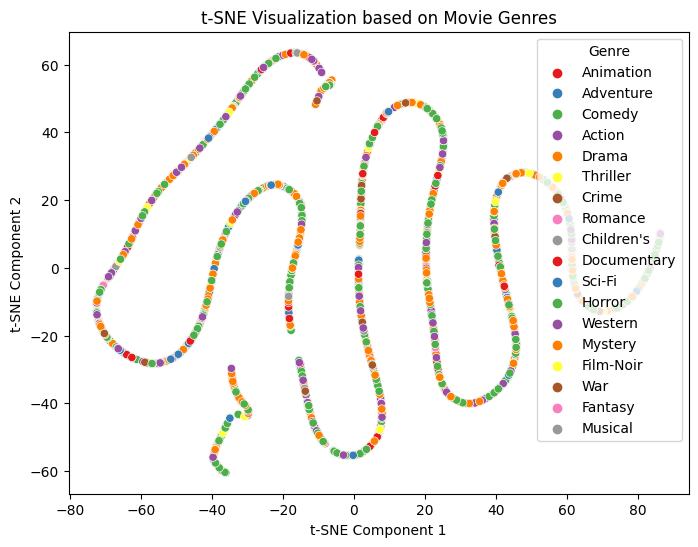

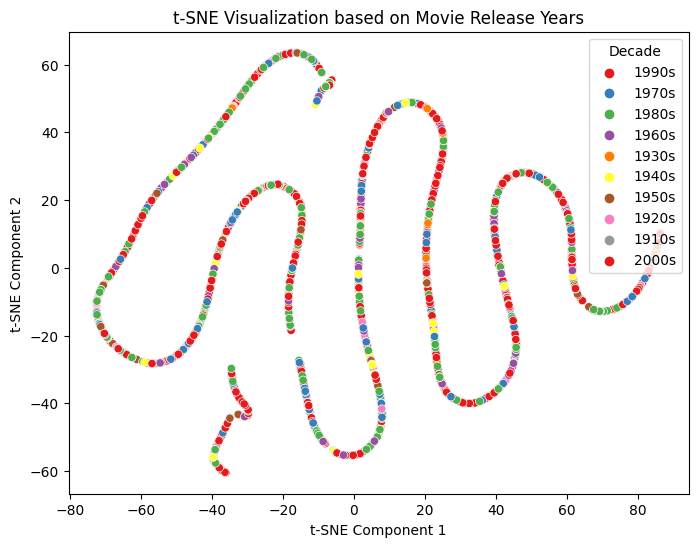

In [ ]:
# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(M)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Extracting genre and year information for labeling
tsne_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  # Extract first genre as an example
tsne_df['Decade'] = movies_df['Decade']

# Plotting based on Genre using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Genre', data=tsne_df, palette='Set1')
plt.title('t-SNE Visualization based on Movie Genres')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Genre')
plt.show()

# Plotting based on Year using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Decade', data=tsne_df, palette='Set1')
plt.title('t-SNE Visualization based on Movie Release Years')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Decade')
plt.show()


# UMAP

C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


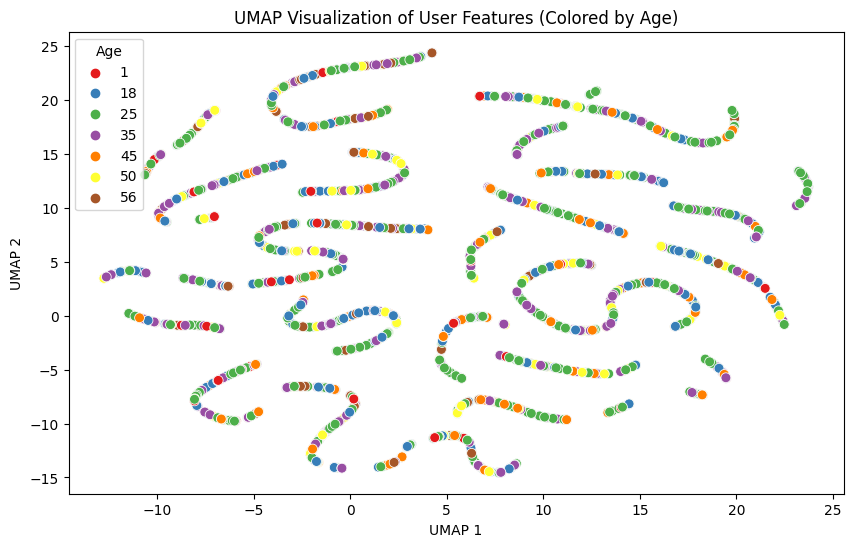

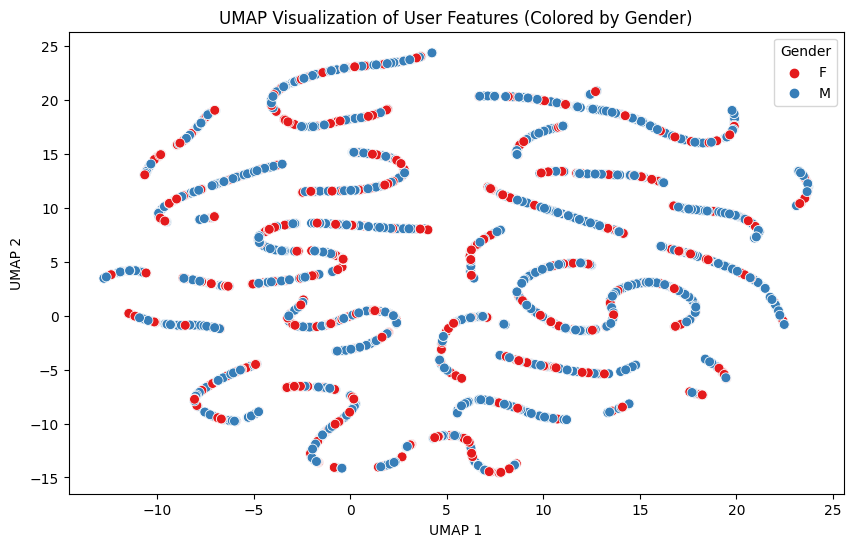

In [ ]:
# Apply UMAP with 2 components for visualization
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(U)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP 1', 'UMAP 2'])

# Concatenate UMAP results with user information
final_umap_df = pd.concat([umap_df, users_df[['Gender', 'Age']]], axis=1)

# Visualize using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Age', data=final_umap_df, palette='Set1', s=50)
plt.title('UMAP Visualization of User Features (Colored by Age)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Alternatively, you can color points by gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Gender', data=final_umap_df, palette='Set1', s=50)
plt.title('UMAP Visualization of User Features (Colored by Gender)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


C:\Users\myria\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


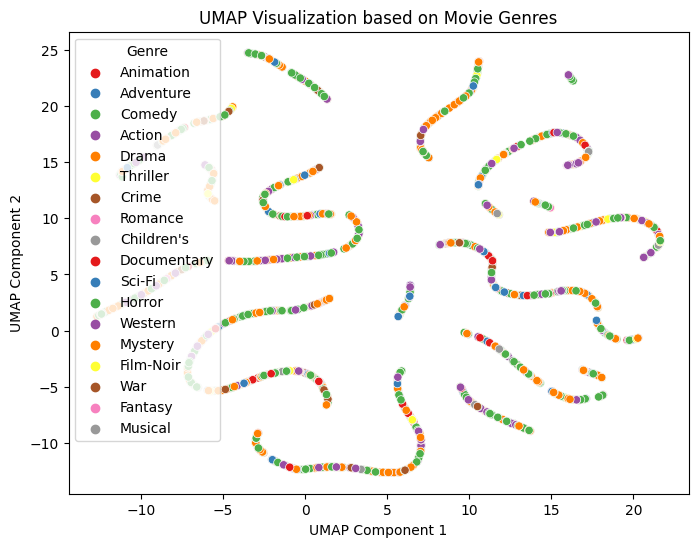

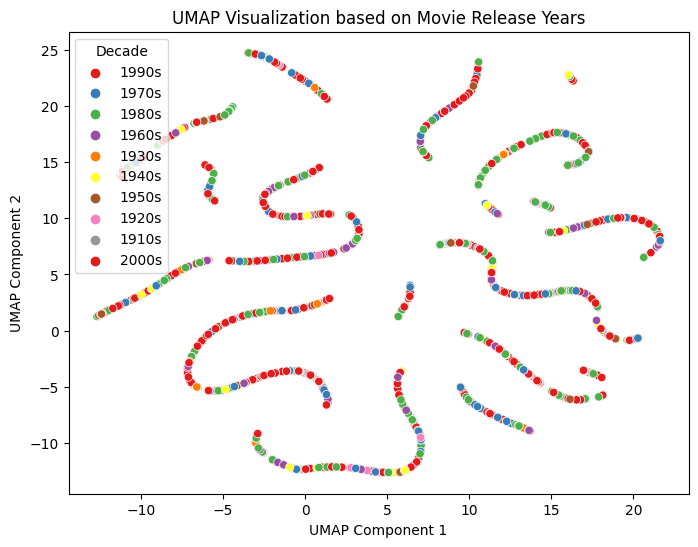

In [ ]:
# Apply UMAP to reduce dimensions
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(M)

# Create a DataFrame for visualization
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Extracting genre and year information for labeling
umap_df['Genre'] = movies_df['Genres'].apply(lambda x: x.split('|')[0])  # Extract first genre as an example
umap_df['Decade'] = movies_df['Decade']

# Plotting based on Genre using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Genre', data=umap_df, palette='Set1')
plt.title('UMAP Visualization based on Movie Genres')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Genre')
plt.show()

# Plotting based on Year using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Decade', data=umap_df, palette='Set1')
plt.title('UMAP Visualization based on Movie Release Years')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Decade')
plt.show()
